In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib
from matplotlib.transforms import offset_copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.text as mtext
import matplotlib.font_manager as mfonts
from matplotlib import patheffects

import cartopy
import cartopy.crs as ccrs
from cartopy.io import img_tiles
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import shapely.geometry as sgeom
from copy import copy

import subprocess as sp
import pandas as pd
import numpy as np
import glob, os
import gdal, osr
%matplotlib inline

In [2]:
def scale_bar(ax, proj, length, location=(0.5, 0.05), linewidth=3):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    #utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    utm = img_tiles.GoogleTiles().crs#ccrs.UTM(36)#ccrs.epsg(28992)#
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * 500, sbcx + length * 500]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' km', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    left = x0+(x1-x0)*0.1
    # Plot the N arrow
#     print('sbcy',sbcy)
#     print('y0',y0)
#     print('y1',y1)    
    t1 = ax.text(left, y1-(y1*0.01), u'\u25B2\nN', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    # Plot the scalebar without buffer, in case covered by text buffer
    buffer = [patheffects.withStroke(linewidth=4, foreground="w")]
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, zorder=3)

In [3]:
# def scale_bar(ax, length, location=(0.5, 0.05), linewidth=3):
#     """
#     ax is the axes to draw the scalebar on.
#     location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
#     length is the length of the scalebar in km.
#     linewidth is the thickness of the scalebar.
#     """
#     #Projection in metres, need to change this to suit your own figure
#     utm = img_tiles.GoogleTiles().crs#ccrs.UTM(36)#ccrs.epsg(28992)#
#     #Get the extent of the plotted area in coordinates in metres
#     x0, x1, y0, y1 = ax.get_extent(utm)
#     #Turn the specified scalebar location into coordinates in metres
#     sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
#     #Generate the x coordinate for the ends of the scalebar
#     bar_xs = [sbcx - length * 500, sbcx + length * 500]
#     #Plot the scalebar
#     ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k', linewidth=linewidth)
#     #Plot the scalebar label
#     ax.text(sbcx, sbcy, str(length) + ' km', transform=utm,
#             horizontalalignment='center', verticalalignment='bottom', size=16)

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)
c = mcolors.ColorConverter().to_rgb

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.
    
        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.
    
    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in xrange(N+1) ]
    # Return colormap object.
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

In [4]:

def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])


def lambert_xticks(ax, ticks, label=True):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    if label == True:        
        ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])
    if label == False:
        ax.set_xticklabels([])
    

def lambert_yticks(ax, ticks, label=True):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    if label == True:
        ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])
    if label == False:
        ax.set_yticklabels([])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:    
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

In [5]:
# create the list of files to use
tifdir = r'D:\Projects\Pr\3492.10\MCD15A3H\tif'
tiffiles = glob.glob(os.path.join(tifdir, 'MCD15A3H.A2016*.tif'))
print (tiffiles[0])

D:\Projects\Pr\3492.10\MCD15A3H\tif\MCD15A3H.A2016093.h18v03.006.2016110204342_projected_Lai_500m.tif


In [6]:
i = r'D:\Projects\Pr\3492.10\MYD13Q1\tif//MYD13Q1.A2016121.h18v03.006.2016140121354_projected_250m 16 days NDVI_clipNL.tif'
ds = gdal.Open(i) 
gt = ds.GetGeoTransform()
rb = ds.GetRasterBand(1)           

# # convert from map to pixel coordinates.    
# px = int((mx - gt[0]) / gt[1]) #x pixel
# py = int((my - gt[3]) / gt[5]) #y pixel

origin_x = gt[0]
origin_y = gt[3]
pixel_width = gt[1]
pixel_height = gt[5]

In [7]:
array = ds.ReadAsArray()

c:\python35\lib\site-packages\cartopy\mpl\geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x000000000FDE1150> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


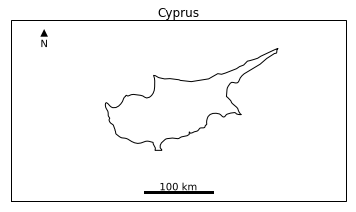

In [8]:
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.Mercator())
plt.title('Cyprus')
ax.set_extent([31, 35.5, 34, 36], ccrs.Geodetic())
ax.coastlines(resolution='10m')

scale_bar(ax, ccrs.Mercator(),100)

plt.show()

In [9]:
proj = ds.GetProjection()

inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj)

print(inproj)

PROJCS["Amersfoort / RD New",
    GEOGCS["Amersfoort",
        DATUM["Amersfoort",
            SPHEROID["Bessel 1841",6377397.155,299.1528128,
                AUTHORITY["EPSG","7004"]],
            TOWGS84[565.4171,50.3319,465.5524,-0.398957,0.343988,-1.87740,4.0725],
            AUTHORITY["EPSG","6289"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4289"]],
    PROJECTION["Oblique_Stereographic"],
    PARAMETER["latitude_of_origin",52.15616055555555],
    PARAMETER["central_meridian",5.38763888888889],
    PARAMETER["scale_factor",0.9999079],
    PARAMETER["false_easting",155000],
    PARAMETER["false_northing",463000],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["X",EAST],
    AXIS["Y",NORTH],
    AUTHORITY["EPSG","28992"]]


In [10]:
import cartopy.crs as ccrs

projcs = inproj.GetAuthorityCode('PROJCS')
projection = ccrs.epsg(projcs)
print(projection)

_EPSGProjection(28992)


In [11]:
outfile_country = r'D:\Projects\Pr\3492.10\shapefiles\Bestuurlijkegrenzen-provincies-actueel-shp//TopGrenzen-prov-actueel.shp'

In [12]:
extent = (gt[0], gt[0] + ds.RasterXSize * gt[1],
          gt[3] + ds.RasterYSize * gt[5], gt[3])

In [13]:
land = cartopy.feature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='10m',
    facecolor='none',
    edgecolor='#dddddd')

boundary_land = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='10m',
    facecolor='none',)

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines', 
    scale='10m',
    facecolor='none',)

In [14]:
xticks = [3,4,5,6,7,8]
yticks = [50,51,52,53,54]

c:\python35\lib\site-packages\cartopy\mpl\geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x00000000111AD410> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


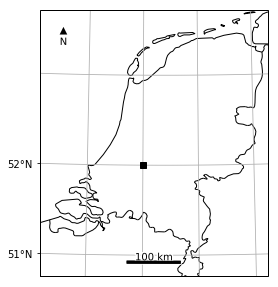

In [15]:
# Draw a set of axes with coastlines:
fig = plt.figure(figsize=(9, 13), frameon=True)
extent_latlon = (3,7.2,50.74466,55)

# PLOT2
ax = plt.subplot(122, projection=projection)
ax.set_extent(extent_latlon, crs=ccrs.PlateCarree())
fig.canvas.draw()
ax.gridlines(xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks, label=True)
lambert_yticks(ax, yticks, label=True)

ax.coastlines(resolution='10m')
#ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(boundary_land, edgecolor='black')

ax.plot(5, 52, marker='s', color='k', markersize=6, transform=ccrs.PlateCarree())
scale_bar(ax, projection,100, location=(0.5,0.05))

#ax.imshow(array, cmap=plt.cm.Blues, vmin=0,vmax=array.max(),
#            interpolation='none', origin='upper', extent=extent, transform=projection)
plt.show()

In [17]:
pkl_file_name = r'D:\Projects\Pr\3492.10\MCD15A3H\pandas//MCD15A3H.006_12locations.pkl'
df = pd.read_pickle(pkl_file_name)

In [18]:
#df = df/10000
df.head()

,Dijkgraaf,Oostwaard,Bankenbos,Haastrecht,Molenweg,Langerak,Cabauw,Kampina,Vredepeel,Fleditebos,Loobos,Lutjewad
2016-04-02,1.2,0.5,0.4,3.2,0.7,2,1.1,0.9,0.6,1,0.6,0.5
2016-04-06,2.1,0.7,0.5,0.9,0.1,1.3,1.3,0.5,0.6,0.8,0.3,0.7
2016-04-10,1.5,1.2,1.5,6.4,1.2,3.4,4.2,0.9,0.8,1.2,2.3,0.7
2016-04-14,2.6,0.3,1.6,0.6,1.2,2.8,2,0.9,0.5,1.7,2.5,0.7
2016-04-18,4,1.3,1.4,1.1,1.4,5,3.1,1.1,0.8,1.9,2.3,0.7


In [19]:
from matplotlib import gridspec

In [20]:
latlon_stations = [['Cabauw', 51.970219444444446, 4.926188888888889],
 ['Bankenbos', 53.02076388888889, 6.402758333333334],
 ['Haastrecht', 52.00313611111111, 4.805508333333333],
 ['Molenweg', 51.65272222222222, 4.636347222222222],
 ['Fleditebos', 52.318333333333335, 5.453333333333333],
 ['Lutjewad', 53.398922222222225, 6.356027777777777],
 ['Langerak', 51.953586111111115, 4.902905555555556],
 ['Oostwaard', 52.831633333333336, 4.909311111111111],
 ['Kampina', 51.566944444444445, 5.2908333333333335],
 ['Loobos', 52.166580555555555, 5.743555555555556],
 ['Vredepeel', 51.53093611111111, 5.84375],
 ['Dijkgraaf', 51.99206111111111, 5.645944444444444]]

c:\python35\lib\site-packages\cartopy\mpl\geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x00000000113F96D0> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


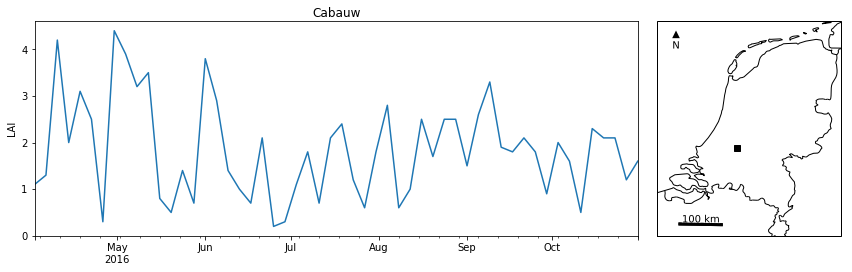

c:\python35\lib\site-packages\cartopy\mpl\geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x000000001118F200> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


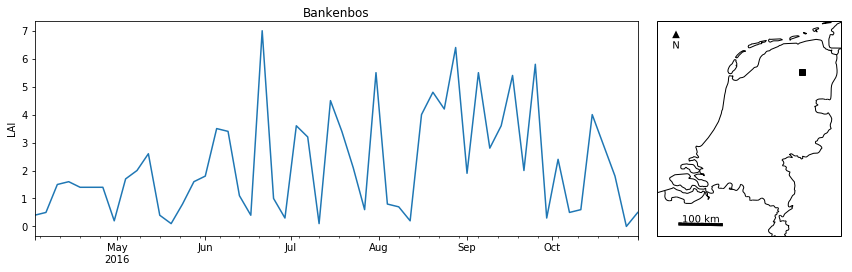

c:\python35\lib\site-packages\cartopy\mpl\geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x00000000115B56D0> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


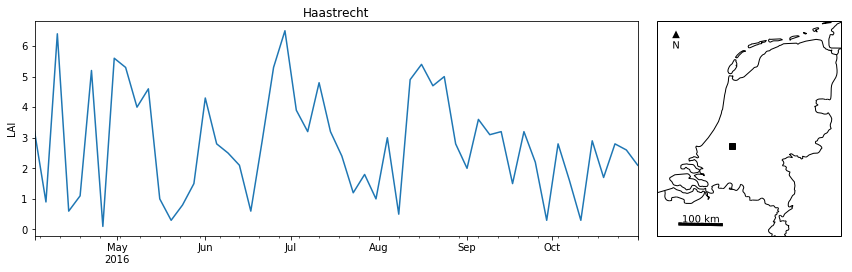

c:\python35\lib\site-packages\cartopy\mpl\geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x00000000116C9BF8> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


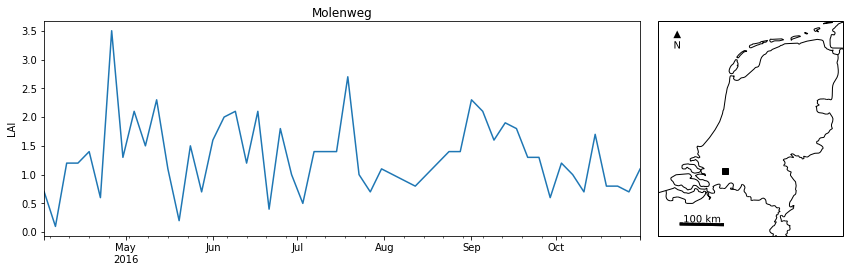

c:\python35\lib\site-packages\cartopy\mpl\geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x0000000011F8B150> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


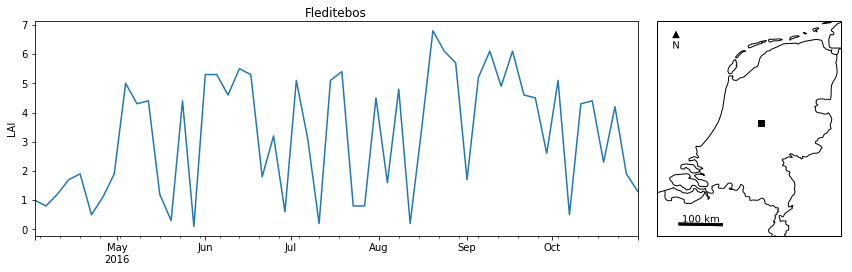

c:\python35\lib\site-packages\cartopy\mpl\geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x0000000011F4D7D8> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


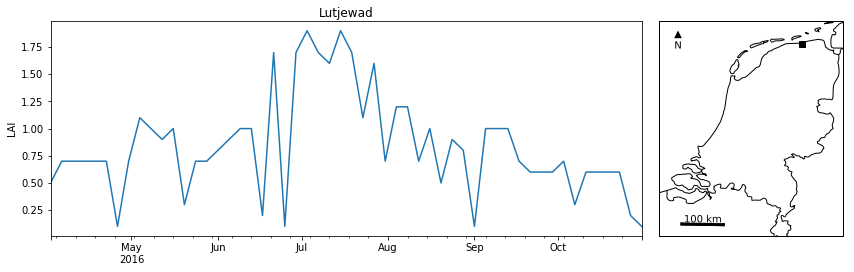

c:\python35\lib\site-packages\cartopy\mpl\geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x00000000111450F8> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


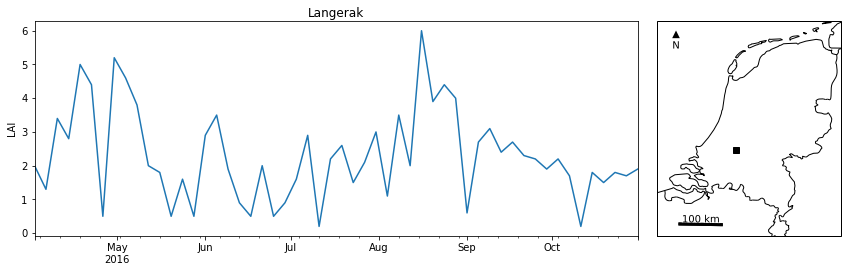

c:\python35\lib\site-packages\cartopy\mpl\geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x0000000011F93830> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


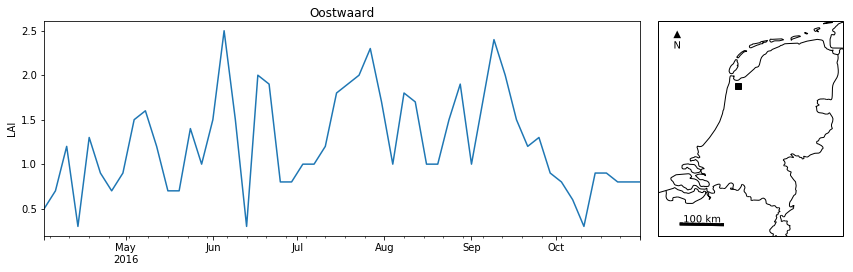

c:\python35\lib\site-packages\cartopy\mpl\geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x000000001117E678> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


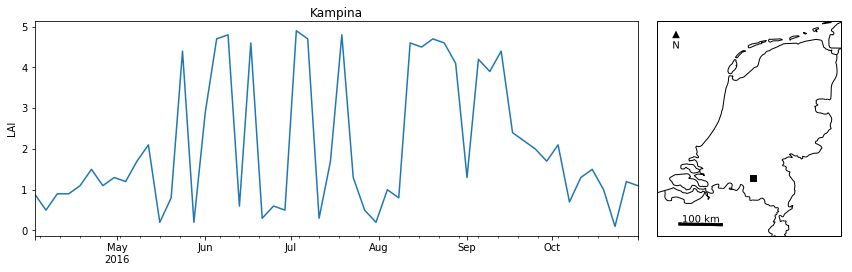

c:\python35\lib\site-packages\cartopy\mpl\geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x0000000011670200> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


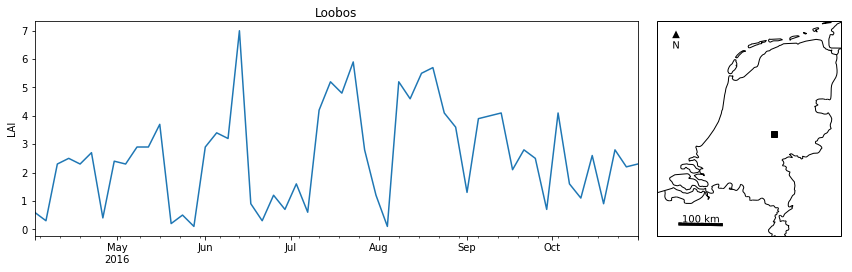

c:\python35\lib\site-packages\cartopy\mpl\geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x000000001138E6D0> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


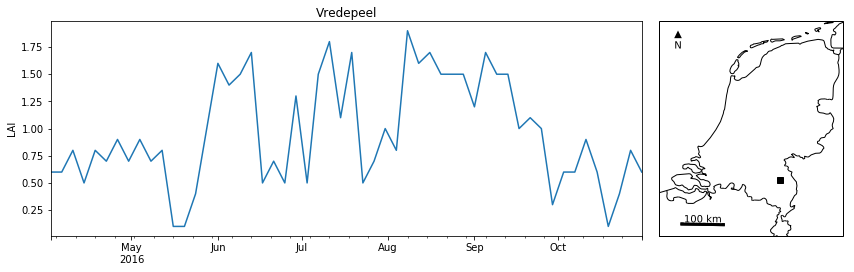

c:\python35\lib\site-packages\cartopy\mpl\geoaxes.py:586: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x0000000012289BA0> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


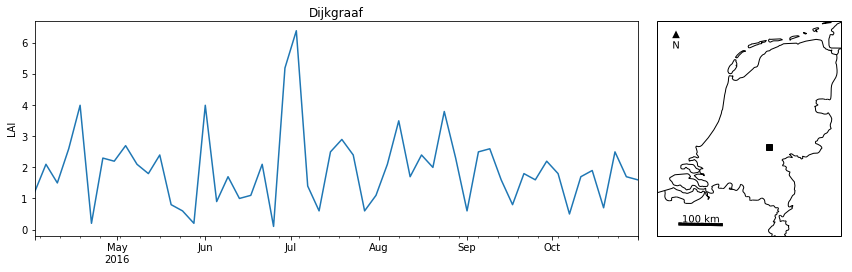

In [21]:
for station in latlon_stations:
    fig = plt.figure(figsize=(12, 13)) 
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1,3]) 
    #ax0 = plt.subplot(gs[0])
    ax0 = plt.subplot(gs[0])
    ax1 = df[station[0]].plot(ax=ax0, grid=None, title=station[0])
    ax1.set_ylabel("LAI")
    # Draw a set of axes with coastlines:
    #fig = plt.figure(figsize=(9, 13), frameon=True)
    extent_latlon = (3,7.2,50.74466,55)

    # PLOT2ax1 = plt.subplot()
    ax = plt.subplot(gs[1], projection=projection)
    ax.set_extent(extent_latlon, crs=ccrs.PlateCarree())
    fig.canvas.draw()
    #ax.gridlines(xlocs=xticks, ylocs=yticks)
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
    #lambert_xticks(ax, xticks, label=False)
    #lambert_yticks(ax, yticks, label=False)

    ax.coastlines(resolution='10m')
    #ax.add_feature(states_provinces, edgecolor='black')
    ax.add_feature(boundary_land, edgecolor='black')

    ax.plot(station[2],station[1], marker='s', color='k', markersize=6, transform=ccrs.PlateCarree())
    scale_bar(ax, projection,100, location=(0.25,0.05))

    #ax.imshow(array, cmap=plt.cm.Blues, vmin=0,vmax=array.max(),
    #            interpolation='none', origin='upper', extent=extent, transform=projection)
    plt.tight_layout()
    plt_out = r'D:\Projects\Pr\3492.10\MCD15A3H\png//ts_plot_'+station[0]+'.png'
    plt.savefig(plt_out, dpi=400, bbox_inches='tight')
    plt.show()